# Clustering Chicago Bike-Share Stations to Understand Rider Behavior

### Jay Irby

In [ ]:
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy
# !pip install glob
# !pip install haversine

In [254]:
# Installing necessary libaries
from haversine import haversine, Unit
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier

In [255]:
# CSVs are monthly, so combine into one year's worth of data
csv_files = glob("data/*.csv")

# Read and combine all monthly CSVs
bikes_df = pd.concat(
    (pd.read_csv(file) for file in csv_files),
    ignore_index=True
)

print(f"Shape: {bikes_df.shape}")

Shape: (5719877, 13)


In [256]:
# Removing missing values
# Since we have a large dataset, I am going to just drop rows with any missing value cols
bikes_df = bikes_df.dropna()

len(bikes_df) 

4331707

In [257]:
causal_ratio = len(bikes_df[bikes_df['member_casual'] == 'casual']) / len(bikes_df)
member_ratio = len(bikes_df[bikes_df['member_casual'] == 'member']) / len(bikes_df)

print(f'The casual rider ratio is: {round(causal_ratio*100, 2)}')
print(f'The member rider ratio is: {round(member_ratio*100, 2)}')

The casual rider ratio is: 35.36
The member rider ratio is: 64.64


In [258]:
# Different types of bikes
set(bikes_df['rideable_type'])

{'classic_bike', 'docked_bike', 'electric_bike'}

In [259]:
classic_ratio = len(bikes_df[bikes_df['rideable_type'] == 'classic_bike']) / len(bikes_df)
docked_ratio = len(bikes_df[bikes_df['rideable_type'] == 'docked_bike']) / len(bikes_df)
electric_ratio = len(bikes_df[bikes_df['rideable_type'] == 'electric_bike']) / len(bikes_df)

print(f'The classic bike rider ratio is: {round(classic_ratio*100, 2)}')
print(f'The docked bike rider ratio is: {round(docked_ratio*100, 2)}')
print(f'The electric bike rider ratio is: {round(electric_ratio*100, 2)}')

The classic bike rider ratio is: 62.12
The docked bike rider ratio is: 1.76
The electric bike rider ratio is: 36.13


## Feature Engineering

Features:

- Average trips per (starting) station per day
- Weekday vs weekend (binary) 
- Average Trip length (euclidean distance traveled)
- Average Trip length (time)
- Seasonality (month of year)
- Member/casual rider ratio
- Classic/docked/electric rider ratio

First, calculate individual feature values in the trip-by-trip df, then aggregate in a station df

In [260]:
# Trip length (time)
bikes_df = bikes_df.copy()
# Convert start and end times to actual datetime columns
bikes_df['started_at'] = pd.to_datetime(bikes_df['started_at'])
bikes_df['ended_at'] = pd.to_datetime(bikes_df['ended_at'])

def calc_trip_time(row):
    '''
    Calculates the trip time in mins, seconds
    Params:
    row: a row of a DataFrame with bike/scooter trip data
    Returns:
    The trip time for a given ride
    '''

    return (row['ended_at'] - row['started_at']).total_seconds() / 60  # In minutes

# Trip time per each ride 
bikes_df['trip_time'] = bikes_df.apply(calc_trip_time, axis=1)


In [261]:
# Casual/member binary encoding

# 1 if a member, 0 if casual
bikes_df["is_member"] = (bikes_df["member_casual"] == "member").astype(int)


In [262]:
# Electric/classic/docked binary encoding
bikes_df["is_classic"] = (bikes_df["rideable_type"] == "classic_bike").astype(int)
bikes_df["is_docked"] = (bikes_df["rideable_type"] == "docked_bike").astype(int)
bikes_df["is_electric"] = (bikes_df["rideable_type"] == "electric_bike").astype(int)

In [263]:
# Trip length (euclidean distance)

def calc_trip_length(row):
    '''
    Calculates the trip length in km using euclidean distance and the Haversine formula.
    Params: 
    row: a row of a DataFrame with bike/scooter trip data
    Returns:
    The ride distance in km
    '''

    # Start coordinates
    start_lat, start_lon = row['start_lat'], row['start_lng']
    # End coordinates
    end_lat, end_lon = row['end_lat'], row['end_lng']

    point1 = (start_lat, start_lon)
    point2 = (end_lat, end_lon)

    # Haversine formula
    return haversine(point1, point2, unit=Unit.KILOMETERS)

# Trip length per each ride
bikes_df['trip_length'] = bikes_df.apply(calc_trip_length, axis=1)

In [264]:
# Seasonality (month of year)

def calc_month(row):
    '''
    Extracts the month from the started_at column
    Params:
    row: a row of a DataFrame with bike/scooter trip data
    Returns:
    The month as an integer (1-12)
    '''

    return row['started_at'].month

# Month of each ride
bikes_df['month'] = bikes_df.apply(calc_month, axis=1)

In [265]:
# Find the distribution of rides per month for each station
# This will give me a sense of seasonality for each station
# For example, if a station has 80% of its rides in June, July, August, 
# it is likely a summer-tourist focused station


month_dist = (
    bikes_df
    .groupby(['start_station_id', 'month'])
    .size()
    .groupby(level=0, group_keys=False) # We grouped by 2 this time, so we need to group by the first level (start_station_id)
    .apply(lambda x: x / x.sum())  # fraction per month
    .unstack(fill_value=0)         # columns = months
)

month_dist.columns = [f'month_{m}' for m in month_dist.columns]

In [266]:
# Now we can aggregate to the station level - going to merge with month_dist later
station_df = bikes_df.groupby('start_station_id').agg(
    avg_trip_length_km = ('trip_length', 'mean'),  # Average trip length in km
    avg_trip_time_mins = ('trip_time', 'mean'),  # Average trip time in minutes
    member_ratio = ('is_member', 'mean'),  # Ratio of members (1 if member, 0 if casual)
    classic_ratio = ('is_classic', 'mean'),  # Ratio of classic bikes
    docked_ratio = ('is_docked', 'mean'),  # Ratio of docked bikes
    electric_ratio = ('is_electric', 'mean'),  # Ratio of electric bikes
    total_trips = ('ride_id', 'count'),  # Total number of trips starting from the station
    lat = ('start_lat', 'median'),  # Median latitude of the station
    lng = ('start_lng', 'median')  # Median longitude of the station
).reset_index()


In [267]:
# Merge month distribution into aggregated station df
station_df = station_df.merge(month_dist, left_on='start_station_id', right_index=True, how='left')
station_df = station_df.rename(columns={'month_1': 'January', 'month_2': 'February', 'month_3': 'March',
                                        'month_4': 'April', 'month_5': 'May', 'month_6': 'June',
                                        'month_7': 'July', 'month_8': 'August', 'month_9': 'September',
                                        'month_10': 'October', 'month_11': 'November', 'month_12': 'December'})
station_df.head()

,start_station_id,avg_trip_length_km,avg_trip_time_mins,member_ratio,classic_ratio,docked_ratio,electric_ratio,total_trips,lat,lng,...,March,April,May,June,July,August,September,October,November,December
0,021320,2.427510,11.303333,0.800000,0.0,0.0,1.0,1165,41.889767,-87.680332,...,0.041202,0.074678,0.132189,0.154506,0.116738,0.124464,0.117597,0.078970,0.074678,0.042918
1,1011,4.122992,24.459195,0.413793,0.0,0.0,1.0,29,41.923803,-87.785777,...,0.034483,0.137931,0.103448,0.241379,0.068966,0.137931,0.034483,0.068966,0.103448,0.068966
2,1012,1.547985,6.860047,0.914894,0.0,0.0,1.0,141,41.804927,-87.609153,...,0.000000,0.000000,0.007092,0.007092,0.007092,0.099291,0.205674,0.326241,0.234043,0.106383
3,1013,2.710573,15.380556,0.500000,0.0,0.0,1.0,6,41.885541,-87.725950,...,0.000000,0.000000,0.166667,0.000000,0.333333,0.333333,0.000000,0.000000,0.166667,0.000000
4,1015,2.422369,17.520833,0.500000,0.0,0.0,1.0,4,41.990152,-87.717210,...,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.250000,0.250000,0.000000,0.000000


In [268]:
bikes_df['date'] = bikes_df['started_at'].dt.normalize()

# --- Active days (days with at least one trip) ---
active_days = (bikes_df.groupby('start_station_id')['date']
                      .nunique()
                      .rename('days_active'))


# Merge day counts into station_df
station_df = (station_df
              .merge(active_days, on='start_station_id', how='left'))

# Compute rates
station_df['avg_trips_per_active_day']   = station_df['total_trips'] / station_df['days_active']

## KMeans

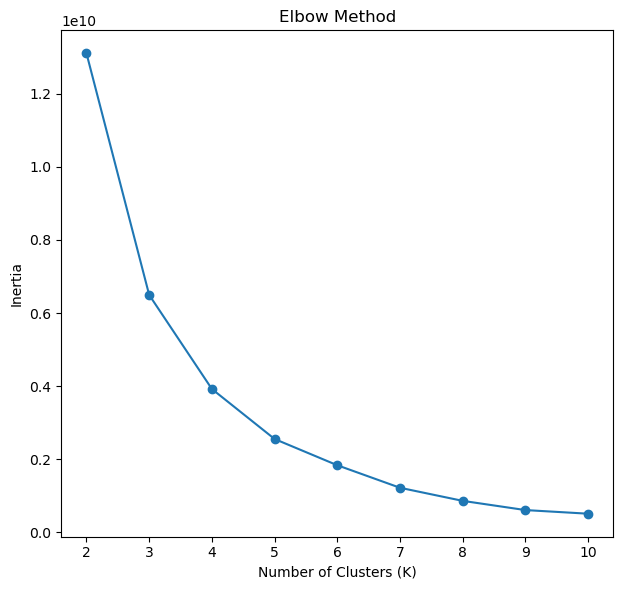

In [269]:
# Isolate numeric features

X = station_df.drop(columns=['start_station_id', 'lat', 'lng'])

# Parameter tuning - finding K using the Elbow method
# Elbow method to find optimal K
inertia = []
silhouette_scores = []
K_range = range(2, 11)  # Testing K from 2 to 10

for K in K_range:
    kmeans = KMeans(n_clusters=K, n_init=50, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plotting the Elbow method
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')

plt.tight_layout()
plt.show()

k = 4-5 looks good

In [270]:
k = 4

# KMeans clustering
kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
station_df['cluster'] = kmeans.fit_predict(X)

## tSNE 2D Dimensionality Reduciton & Visualization

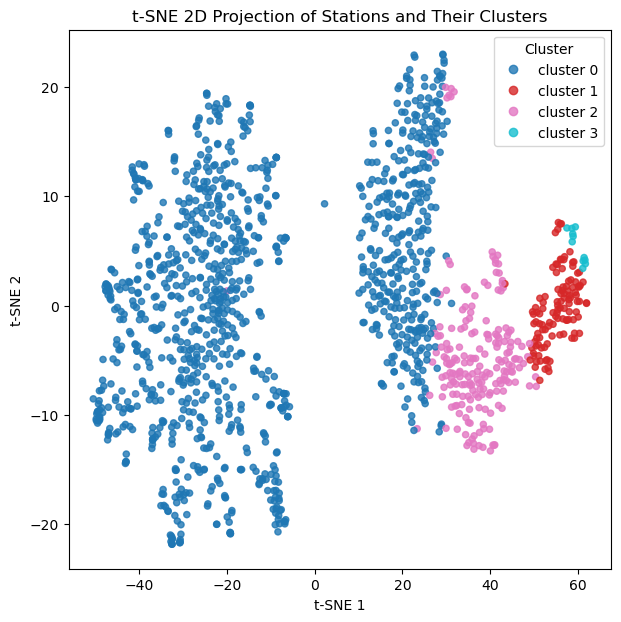

In [271]:
# Select features for t-SNE
# Exclude 'start_station_id' and 'cluster' columns
feature_names = ['avg_trip_length_km', 'avg_trip_time_mins',
       'member_ratio', 'classic_ratio', 'docked_ratio', 'electric_ratio',
       'total_trips', 'January', 'February', 'March', 'April',
       'May', 'June', 'July', 'August', 'September', 'October', 'November',
       'December', 'avg_trips_per_active_day',]
X_vals = station_df[feature_names].values

# Standardize features
Xs = StandardScaler().fit_transform(X_vals)

# t-SNE
tsne = TSNE(
    n_components=2, # 2D projection
    n_iter=1000,
    perplexity=40, # 30-50 is good here
    random_state=1236,
    n_jobs=-1
)

# Reduced embedding
X_tsne = tsne.fit_transform(Xs)

# Plot
plt.figure(figsize=(7,7))
scatter = plt.scatter(*X_tsne.T, 
                      c=station_df['cluster'], cmap="tab10", s=20, alpha=0.8)
handles, labels = scatter.legend_elements()
plt.legend(handles, [f"cluster {i}" for i in range(len(handles))], title="Cluster")
plt.title("t-SNE 2D Projection of Stations and Their Clusters")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.show()


## Heat Map Of Clusters and Features

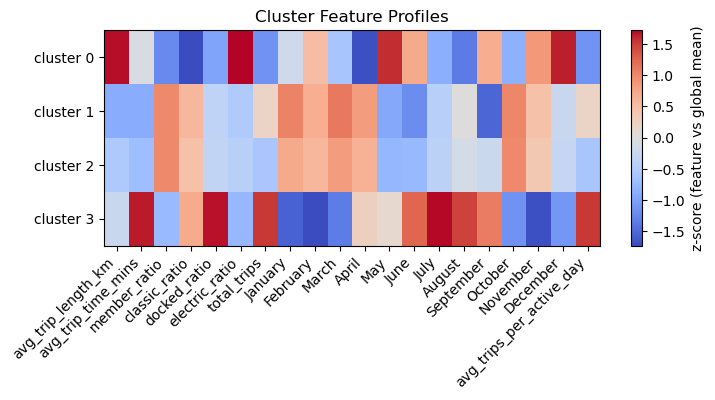

In [272]:
# Compute cluster means
X_df = station_df[feature_names].copy()

X_df['cluster'] = station_df['cluster'].values
cluster_means = X_df.groupby('cluster')[feature_names].mean()

# z-score across clusters for each feature (better for visualization)
cluster_means_z = (cluster_means - cluster_means.mean()) / cluster_means.std(ddof=0)

# Plot heatmap
fig, ax = plt.subplots(figsize=(max(6, len(feature_names)*0.4), 0.7*len(cluster_means)))
im = ax.imshow(cluster_means_z.values, aspect='auto', cmap="coolwarm")

ax.set_xticks(np.arange(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=45, ha="right")
ax.set_yticks(np.arange(len(cluster_means_z)))
ax.set_yticklabels([f"cluster {c}" for c in range(4)])

plt.colorbar(im, ax=ax, label="z-score (feature vs global mean)")
plt.title("Cluster Feature Profiles")
plt.show()


## Geospatial Visualization of Stations and Their Assigned Cluster

In [273]:
# Geospatial visualization of stations and their assigned cluster

# Convert cluster to string for better visualization
station_df['cluster'] = station_df['cluster'].astype(str)
fig = px.scatter_mapbox(
    station_df, lat="lat", lon="lng",
    color="cluster", 
    hover_data=feature_names, 
    zoom=9, height=600,
    color_discrete_sequence=px.colors.qualitative.Set1
)
fig.update_layout(mapbox_style="open-street-map",
                  margin=dict(l=0,r=0,t=40,b=0),
                  title="Stations by Cluster - Chicago Bikes/Scooters Rides")
fig.show()


## Exploration and Analysis

In [274]:
# Quick summary of clusters - means
cluster_means = station_df.groupby("cluster")[feature_names].mean()
print(cluster_means)

         avg_trip_length_km  avg_trip_time_mins  member_ratio  classic_ratio  \
cluster                                                                        
0                  2.948485           16.979112      0.477224       0.206788   
1                  1.955271           14.924080      0.666002       0.636261   
2                  2.095918           15.429221      0.667122       0.616868   
3                  2.211537           21.228025      0.518354       0.658737   

         docked_ratio  electric_ratio   total_trips   January  February  \
cluster                                                                   
0            0.008331        0.784882    397.705779  0.030450  0.035150   
1            0.015104        0.348636  17443.394737  0.036322  0.035821   
2            0.015320        0.367812   7533.388060  0.034713  0.035399   
3            0.037395        0.303868  34069.909091  0.023949  0.026145   

            March     April       May      June      July    August 

In [275]:
# Kruskal-Wallis test for feature differences across clusters
# This is a non-parametric test to compare distributions across multiple groups

results = []
for feat in feature_names:
    groups = [station_df.loc[station_df['cluster']==c, feat] 
              for c in station_df['cluster'].unique()]
    H, p = stats.kruskal(*groups)  
    results.append((feat, H, p))

anova_results = pd.DataFrame(results, columns=["Feature", "H_stat", "p_value"])
anova_results.sort_values("p_value", inplace=True)
print(anova_results)


                     Feature      H_stat        p_value
19  avg_trips_per_active_day  772.904249  3.254907e-167
6                total_trips  772.199113  4.628701e-167
3              classic_ratio  458.123286   5.664592e-99
5             electric_ratio  434.082694   9.159334e-94
4               docked_ratio  308.232275   1.644346e-66
2               member_ratio  166.997350   5.660549e-36
7                    January  162.008663   6.755093e-35
9                      March  126.134064   3.682098e-27
8                   February  122.355631   2.399226e-26
16                   October  114.963882   9.372612e-25
10                     April   81.997390   1.144290e-17
17                  November   77.338355   1.142451e-16
14                    August   53.440724   1.476660e-11
18                  December   45.269898   8.107845e-10
13                      July   41.084969   6.273402e-09
15                 September   37.257580   4.058696e-08
12                      June   18.345520   3.732

In [276]:
# Silhouette score for the clustering
# This measures how similar an object is to its own cluster compared to other clusters

X_vals = station_df[feature_names].values
score = silhouette_score(X_vals, station_df['cluster'])
print("Silhouette Score:", score)

Silhouette Score: 0.8153145498305389


A silhouette score of ~0.81 suggests that features contain clear grouping patterns. A given station is very similar to its own cluster than the other clusters.

# Random Forest Classifier

Predicts which cluster a given station belongs to based off the features. This will show what features are the most important in defining the clusters.

In [277]:
# Feature importance using Random Forest
# This will give us an idea of which features are most important for clustering

# Super simple feature importance using Random Forest, nothing crazy here
# No need to train since we are just using it for feature importance

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_vals, station_df['cluster'])
importances = pd.Series(rf_model.feature_importances_, index=feature_names)
print(importances.sort_values(ascending=False))


total_trips                 0.394293
avg_trips_per_active_day    0.349298
electric_ratio              0.053978
classic_ratio               0.048932
docked_ratio                0.023584
April                       0.019583
October                     0.017773
member_ratio                0.016104
avg_trip_time_mins          0.013211
January                     0.009590
February                    0.007439
March                       0.007021
May                         0.006492
September                   0.006411
avg_trip_length_km          0.006290
August                      0.004751
November                    0.004599
July                        0.003715
June                        0.003551
December                    0.003385
dtype: float64


# Analysis and Insights Report

KMeans identified 4 distinct clusters (silhouette = 0.81). The silhouette score portrays how similar a station/object is to its own cluster compared to other clusters. The score ranges from -1 to 1, so a score of 0.81 suggests that the station features contain strong, clear grouping patterns.

Kruskal–Wallis tests confirmed that differences in avg_trips_per_active_day and total_trips were highly statistically significant (p < 1e-160), indicating these variables are the primary drivers of station differences

A Random Forest classifier confirmed that total trips and average trips per hour together explain ~74% of the clustering variance.

Since two variables were incredibly imporant, with the other variables playing minor roles, each cluster was laregely defined by the two variables: avg_trips_per_active_day and total_trips.

Cluster 0 had the least amount of traffic, with roughly 2 trips per day averaged across all of the stations within this cluster. This makes total sense, as by looking at the map, all of these stations are located in the suburbs, extremely far away from city centers. Mostly automobiles are used here, and e-bikes and scooters are not as useful. Also, this cluster had the largest percentage of electric bike rides at a staggering 78.5%. This is likely due to the need to travel long distances in the suburbs. Also, cluster 0 has the longest average ride length at 2.9km. This cluster clearly shows the suburban stations and subsequent suburban rider behavior. 

Cluster 1, 2, and 3 all have significantly more traffic. Interestingly, the clusters are somewhat defined by how close they are to Chicago's main city center and downtown area. Cluster 2 has the second least amount of rides per day, and the stations within this closer are all further away from downtown. 

Cluster 3 is extremely unique. This cluster has very few stations (11 total), but the average number of trips per day among these stations is 93, which is 50 rides greater than the second busiest cluster. These stations are the hotspots; these stations could be large hubs where the bike companies maintain and place a large quantity of vehicles. These stations are also in the heart of downtown. There is a 50/50 split between members and casual riders. 

Cluster 1 is a medium between cluster 3 and 2. Cluster 1 stations are all located near the city center and have a lot of traffic. 67% of riders are members, so these stations are likely used by Chicago residents and workers. These riders likely use the service to commute to work or to leisure activites.

Seasonality does not play a huge role. This is probably due to the majrority (64%) of riders being members, so regular residents use the bikes far more often than tourists. 



# Technical Details and Methodology

## Feature Engineering

- Used Pandas functions and created my own functions to calculate certain features, and used apply() to create new feature columns.

- For most of the features, I calculated them on a ride-by-ride basis, and then averaged them out to aggregate on the station level. Then, I had average measurements of all the rides for each given station.

## KMeans

- I used the elbow method to determine the most optimal k value -- the number of clusters.

## tSNE

- I used tSNE to reduce the dimensionality of my df so I could visiualize my clusters in 2D. I saw very clear clustering and a variety in cluster sizes. 

- I had to standardize all of my variables since tSNE relies on euclidean distance measuremnts for embedding. Since all of my features had different scales, I needed to convert them all on to the same, standardized scale. I did this by using StandardScalar().

- I used a perplexity of 40, meaning t-SNE considered each station’s 40 nearest neighbors when constructing the low-dimensional embedding. In this process, t-SNE relies on Euclidean distance to measure similarity between stations, so stations with similar feature profiles are placed closer together in the 2D projection. Stations with more similar feature values (in the original high-dimensional space) are assigned a higher probability of being mapped close together in the 2D projection.

- Ultimately, I used tSNE because I had few enough rows/stations (~1400), and I wanted to capture non-linear relationships. 

## Random Forest

- I trained a Random Forest classifier using the cluster assignments as labels.

- The model was fit on the full dataset (no train/test split), since the goal was not prediction but understanding feature importance.

- By analyzing the trained model, I identified which features were most influential in determining the cluster assignments.

- This provides insight into which station characteristics contributed most strongly to the clustering results.